In [ ]:
!git clone https://github.com/lih627/CamVid.git

Cloning into 'CamVid'...
remote: Enumerating objects: 2834, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2834 (delta 0), reused 1 (delta 0), pack-reused 2831 (from 1)
Receiving objects: 100% (2834/2834), 595.30 MiB | 18.77 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (2815/2815), done.


<h3>Required Libraries</h3>

In [ ]:
import os
import glob
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from tqdm import tqdm

<h1>Dataset Visualization</h1>

In [ ]:
# Paths
rgb_dir = './CamVid/CamVid_RGB'
label_dir = './CamVid/CamVidColor11'

# List and sort files to align them
rgb_images = sorted([os.path.join(rgb_dir, f) for f in os.listdir(rgb_dir) if f.endswith('.png') or f.endswith('.jpg')])
label_images = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.png') or f.endswith('.jpg')])

# Sanity check
print(f"Found {len(rgb_images)} RGB images and {len(label_images)} label images.")

Found 701 RGB images and 701 label images.


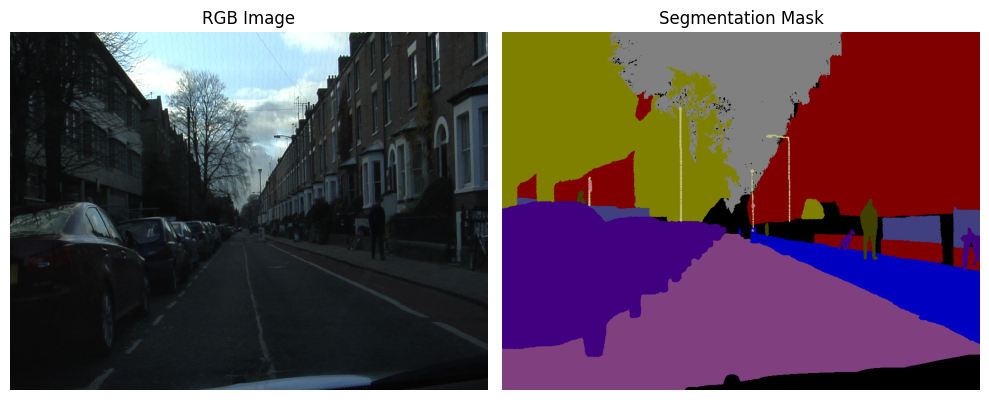

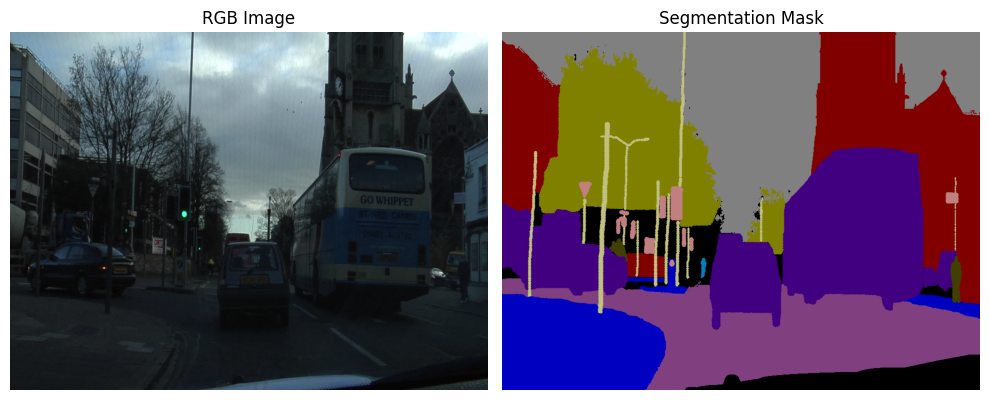

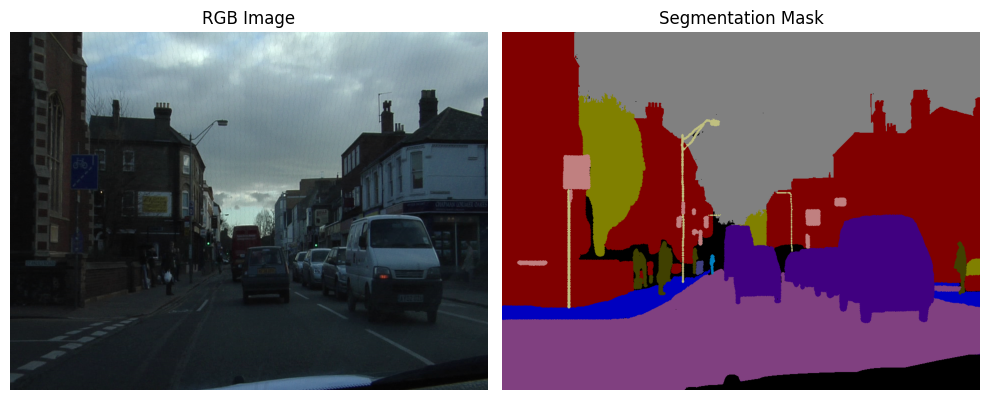

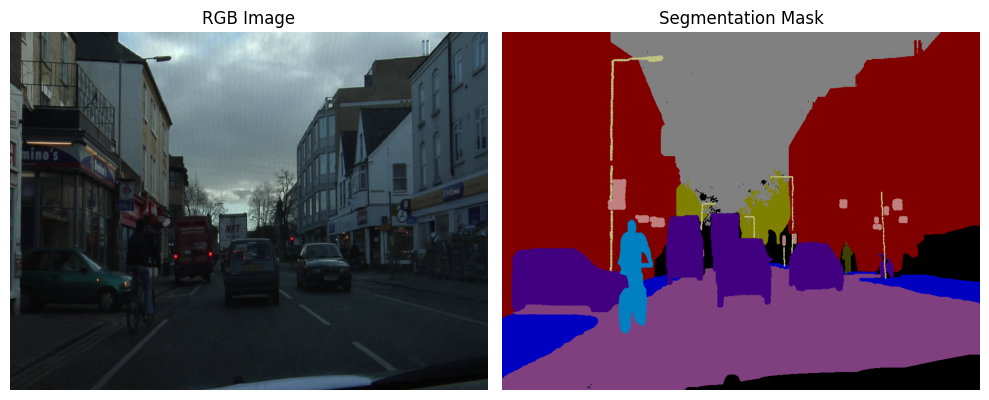

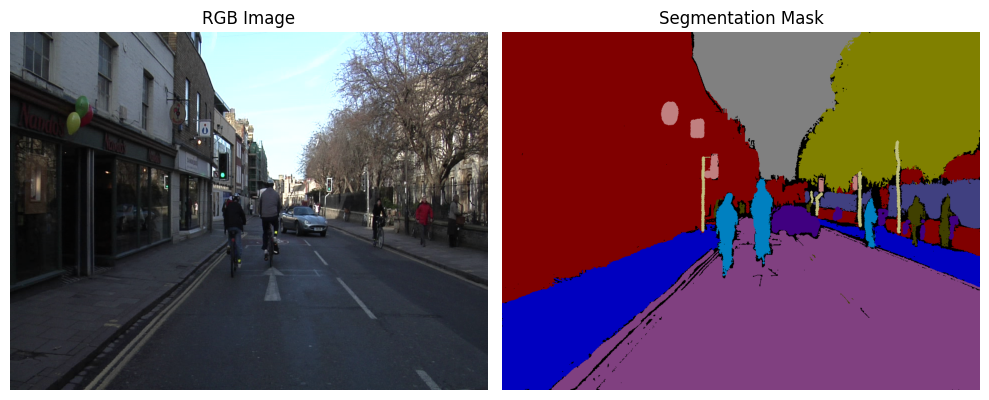

In [ ]:
# Plot a few examples
num_examples = 5
for _ in range(num_examples):
    i = random.randint(0, len(rgb_images))
    rgb = Image.open(rgb_images[i])
    label = Image.open(label_images[i])

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.title("RGB Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(label)
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Build Color→ClassID Mapping

# 1) Define the RGB→class-name map
RGBLabel2LabelName = {
    (128,128,128): "Sky",
    (0,128,64):     "Building", (128,0,0): "Building", (64,192,0): "Building",
    (64,0,64):      "Building", (192,0,128): "Building",
    (192,192,128):  "Pole", (0,0,64): "Pole",
    (128,64,128):   "Road", (128,0,192): "Road", (192,0,64): "Road",
    (0,0,192):      "Sidewalk", (64,192,128): "Sidewalk", (128,128,192): "Sidewalk",
    (128,128,0):    "Tree", (192,192,0): "Tree",
    (192,128,128):  "SignSymbol", (128,128,64): "SignSymbol", (0,64,64): "SignSymbol",
    (64,64,128):    "Fence",
    (64,0,128):     "Car", (64,128,192): "Car", (192,128,192): "Car",
    (192,64,128):   "Car", (128,64,64):  "Car",
    (64,64,0):      "Pedestrian", (192,128,64): "Pedestrian",
    (64,0,192):     "Pedestrian", (64,128,64): "Pedestrian",
    (0,128,192):    "Bicyclist", (192,0,192): "Bicyclist",
    (0,0,0):        "Void"
}

# 2) Deduplicate label names to create a class list
label_names = sorted(set(RGBLabel2LabelName.values()))
class2id = {name: idx for idx, name in enumerate(label_names)}
color2id = {rgb: class2id[name] for rgb, name in RGBLabel2LabelName.items()}

print(f"Classes ({len(label_names)}):", label_names)
print("Example mapping:", list(color2id.items())[:5])


Classes (12): ['Bicyclist', 'Building', 'Car', 'Fence', 'Pedestrian', 'Pole', 'Road', 'Sidewalk', 'SignSymbol', 'Sky', 'Tree', 'Void']
Example mapping: [((128, 128, 128), 9), ((0, 128, 64), 1), ((128, 0, 0), 1), ((64, 192, 0), 1), ((64, 0, 64), 1)]


In [ ]:
# Configuration
NUM_CLASSES   = len(label_names)
INPUT_HEIGHT  = 360
INPUT_WIDTH   = 480
BATCH_SIZE    = 16
NUM_EPOCHS    = 20
LEARNING_RATE = 1e-3

RGB_DIR  = './CamVid/CamVid_RGB'
MASK_DIR = './CamVid/CamVid_Label'
DEVICE   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class CamVidDataset(Dataset):
    def __init__(self, rgb_dir, mask_dir, color2id, img_size=(360,480)):
        self.rgb_paths  = sorted(glob.glob(f"{rgb_dir}/*"))
        self.mask_paths = sorted(glob.glob(f"{mask_dir}/*"))
        self.color2id   = color2id
        self.img_size   = img_size

        # Image transforms
        self.img_transform = transforms.Compose([
            transforms.Resize(img_size, interpolation=Image.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        # Load & transform RGB
        img = Image.open(self.rgb_paths[idx]).convert('RGB')
        img = self.img_transform(img)  # [3, H, W]

        # Load mask (RGB), resize, convert to numpy
        mask = Image.open(self.mask_paths[idx]).convert('RGB')
        mask = mask.resize(self.img_size[::-1], Image.NEAREST)
        arr = np.array(mask, dtype=np.uint8)  # (H, W, 3)

        # Map each pixel to class ID
        h, w, _ = arr.shape
        id_map = np.zeros((h, w), dtype=np.int64)
        for rgb, cid in self.color2id.items():
            matches = (arr == rgb).all(axis=-1)
            id_map[matches] = cid

        # Convert to tensor
        mask_tensor = torch.from_numpy(id_map)

        return img, mask_tensor


In [ ]:
# DataLoader Setup

from torch.utils.data import DataLoader

IMG_SIZE = (360, 480)

train_ds = CamVidDataset(
    rgb_dir=RGB_DIR,
    mask_dir=MASK_DIR,
    img_size=IMG_SIZE,
    color2id=color2id
)
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Sanity check shapes
img, mask = train_ds[0]
print("Image shape:", img.shape)   # should be [3,360,480]
print("Mask shape:", mask.shape)   # should be [360,480]
print("Unique labels:", torch.unique(mask))


Image shape: torch.Size([3, 360, 480])
Mask shape: torch.Size([360, 480])
Unique labels: tensor([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11])


<h1>Data Split</h1>

In [ ]:
# Train/Validation Split

from torch.utils.data import random_split

# Total size
dataset_size = len(train_ds)
train_size   = int(0.9 * dataset_size)
val_size     = dataset_size - train_size

# Make the split
train_subset, val_subset = random_split(
    train_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# DataLoaders
train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train samples: {len(train_subset)}, Val samples: {len(val_subset)}")


Train samples: 630, Val samples: 71


<h1>Model Definition</h1>

In [ ]:
# FastSCNN Model Definition


# Depthwise Separable Convolution
class DSConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size, stride, padding, groups=in_ch, bias=False)
        self.pointwise = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

# Inverted Residual Bottleneck (MobileNetV2 style)
class Bottleneck(nn.Module):
    def __init__(self, in_ch, out_ch, expansion, stride):
        super().__init__()
        hidden_dim = in_ch * expansion
        self.use_res_connect = (stride == 1 and in_ch == out_ch)
        self.block = nn.Sequential(
            # expand
            nn.Conv2d(in_ch, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            # depthwise
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            # project
            nn.Conv2d(hidden_dim, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.block(x)
        else:
            return self.block(x)

# Pyramid Pooling Module
class PPM(nn.Module):
    def __init__(self, in_ch, out_ch, pool_sizes=(1, 2, 3, 6)):
        super().__init__()
        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(ps),
                nn.Conv2d(in_ch, out_ch, 1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            ) for ps in pool_sizes
        ])
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_ch + len(pool_sizes)*out_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        h, w = x.size(2), x.size(3)
        pyramids = [x] + [F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=False)
                          for stage in self.stages]
        output = torch.cat(pyramids, dim=1)
        return self.bottleneck(output)

# Learning to Downsample Module
class LearningToDownsample(nn.Module):
    def __init__(self, in_ch=3, out_ch=32):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        self.dsconv1 = DSConv(out_ch, out_ch*2, stride=2)
        self.dsconv2 = DSConv(out_ch*2, out_ch*4, stride=2)

    def forward(self, x):
        x = self.conv(x)        # downsample ×2
        x = self.dsconv1(x)     # downsample ×2
        x = self.dsconv2(x)     # downsample ×2 (total ×8)
        return x

# Global Feature Extractor
class GlobalFeatureExtractor(nn.Module):
    def __init__(self, in_ch, block_channels, expansions, repeats, ppm_out_ch):
        super().__init__()
        layers = []
        for out_ch, exp, r in zip(block_channels, expansions, repeats):
            for i in range(r):
                stride = 2 if i == 0 else 1
                layers.append(Bottleneck(in_ch, out_ch, exp, stride))
                in_ch = out_ch
        self.bottlenecks = nn.Sequential(*layers)
        self.ppm = PPM(in_ch, ppm_out_ch)

    def forward(self, x):
        x = self.bottlenecks(x)
        x = self.ppm(x)
        return x

# Feature Fusion Module
class FeatureFusionModule(nn.Module):
    def __init__(self, high_ch, low_ch, out_ch):
        super().__init__()
        self.low_res_conv = nn.Sequential(
            nn.Conv2d(low_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        )
        self.high_res_ds = DSConv(high_ch, out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, high_res, low_res):
        low_res_upsampled = F.interpolate(low_res, size=high_res.shape[2:], mode='bilinear', align_corners=False)
        low_res_conv = self.low_res_conv(low_res_upsampled)
        high_res_ds = self.high_res_ds(high_res)
        return self.relu(high_res_ds + low_res_conv)

# Classifier Module
class Classifier(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.dsconv1 = DSConv(in_ch, in_ch)
        self.dsconv2 = DSConv(in_ch, in_ch)
        self.out_conv = nn.Conv2d(in_ch, num_classes, 1)

    def forward(self, x):
        x = self.dsconv1(x)
        x = self.dsconv2(x)
        x = self.out_conv(x)
        return x

# Fast-SCNN Model
class FastSCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # downsample path
        self.down = LearningToDownsample(in_ch=3, out_ch=32)
        # global feature extractor path
        self.global_feat = GlobalFeatureExtractor(
            in_ch=32*4,                     # 128 channels from downsample
            block_channels=[64, 96, 128],
            expansions=[6, 6, 6],
            repeats=[3, 3, 3],
            ppm_out_ch=128
        )
        # feature fusion and classifier
        self.ffm = FeatureFusionModule(high_ch=32, low_ch=128, out_ch=128)
        self.classifier = Classifier(in_ch=128, num_classes=num_classes)

    def forward(self, x):
        # high-res detail from first conv
        high_res = self.down.conv(x)      # (B,32,H/2,W/2)
        x = self.down(x)                  # (B,128,H/8,W/8)
        x = self.global_feat(x)           # (B,128,H/8,W/8)
        x = self.ffm(high_res, x)         # (B,128,H/8,W/8)
        x = self.classifier(x)            # (B,num_classes,H/8,W/8)
        x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=False)
        return x

# Instantiate and print
model = FastSCNN(num_classes=NUM_CLASSES).to(DEVICE)
print(model)

FastSCNN(
  (down): LearningToDownsample(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (dsconv1): DSConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32, bias=False)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (dsconv2): DSConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (global_feat): GlobalFeat

<h1>Training</h1>

In [ ]:
# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [ ]:
# to compute per-class Dice and mean Dice
def compute_dice(pred, true, num_classes):
    dice_scores = []
    for cls in range(num_classes):
        pred_i = (pred == cls)
        true_i = (true == cls)
        inter = (pred_i & true_i).sum().float()
        total = pred_i.sum().float() + true_i.sum().float()
        dice_scores.append((2*inter / (total + 1e-6)).item() if total>0 else float('nan'))
    valid = [d for d in dice_scores if not torch.isnan(torch.tensor(d))]
    return sum(valid)/len(valid) if valid else float('nan')

# to compute mean IoU
def compute_miou(pred, true, num_classes):
    intersection = torch.zeros(num_classes, device=DEVICE)
    union = torch.zeros(num_classes, device=DEVICE)
    pred_flat = pred.view(-1)
    true_flat = true.view(-1)
    for cls in range(num_classes):
        pred_i = (pred_flat == cls)
        true_i = (true_flat == cls)
        inter = (pred_i & true_i).sum().float()
        uni   = (pred_i | true_i).sum().float()
        intersection[cls] += inter
        union[cls] += uni
    iou = intersection / (union + 1e-6)
    return iou.mean().item()


In [ ]:
# Initialize logs
train_losses, val_losses = [], []
train_mious,  val_mious  = [], []
train_dices,  val_dices  = [], []
train_accs,   val_accs   = [], []

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for imgs, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{NUM_EPOCHS}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

        preds = model(imgs)
        preds = F.interpolate(preds, size=masks.shape[1:], mode='bilinear', align_corners=False)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)

        # Accuracy: count correct pixels
        pred_labels = torch.argmax(preds, dim=1)
        correct += (pred_labels == masks).sum().item()
        total   += masks.numel()

    scheduler.step()
    avg_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_acc = correct / total
    train_accs.append(train_acc)

    # Compute Train mIoU & Dice on full train set
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            preds = F.interpolate(preds, size=masks.shape[1:], mode='bilinear', align_corners=False)
            all_preds.append(torch.argmax(preds, dim=1))
            all_trues.append(masks)
    train_pred = torch.cat(all_preds)
    train_true = torch.cat(all_trues)
    train_miou = compute_miou(train_pred, train_true, NUM_CLASSES)
    train_dice = compute_dice(train_pred, train_true, NUM_CLASSES)
    train_mious.append(train_miou)
    train_dices.append(train_dice)

    # --- Validation Phase ---
    running_val_loss = 0.0
    correct, total = 0, 0
    val_preds, val_trues = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            preds = F.interpolate(preds, size=masks.shape[1:], mode='bilinear', align_corners=False)

            running_val_loss += criterion(preds, masks).item() * imgs.size(0)

            pred_labels = torch.argmax(preds, dim=1)
            correct += (pred_labels == masks).sum().item()
            total   += masks.numel()

            val_preds.append(pred_labels)
            val_trues.append(masks)

    avg_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    val_acc = correct / total
    val_accs.append(val_acc)

    val_pred = torch.cat(val_preds)
    val_true = torch.cat(val_trues)
    val_miou = compute_miou(val_pred, val_true, NUM_CLASSES)
    val_dice = compute_dice(val_pred, val_true, NUM_CLASSES)
    val_mious.append(val_miou)
    val_dices.append(val_dice)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
        f"Train mIoU: {train_miou:.4f} | Val mIoU: {val_miou:.4f} | "
        f"Train Dice: {train_dice:.4f} | Val Dice: {val_dice:.4f}"
    )

Train Epoch 1/20: 100%|██████████| 40/40 [02:00<00:00,  3.00s/it]


Epoch 1/20 | Train Loss: 1.1093 | Val Loss: 1.1791 | Train Acc: 0.6738 | Val Acc: 0.6223 | Train mIoU: 0.1834 | Val mIoU: 0.1785 | Train Dice: 0.2423 | Val Dice: 0.2356


Train Epoch 2/20: 100%|██████████| 40/40 [01:57<00:00,  2.94s/it]


Epoch 2/20 | Train Loss: 0.6318 | Val Loss: 0.5717 | Train Acc: 0.8089 | Val Acc: 0.8265 | Train mIoU: 0.3864 | Val mIoU: 0.3809 | Train Dice: 0.4594 | Val Dice: 0.4565


Train Epoch 3/20: 100%|██████████| 40/40 [01:58<00:00,  2.95s/it]


Epoch 3/20 | Train Loss: 0.5103 | Val Loss: 0.5283 | Train Acc: 0.8449 | Val Acc: 0.8307 | Train mIoU: 0.4300 | Val mIoU: 0.4073 | Train Dice: 0.5118 | Val Dice: 0.4916


Train Epoch 4/20: 100%|██████████| 40/40 [01:55<00:00,  2.89s/it]


Epoch 4/20 | Train Loss: 0.4487 | Val Loss: 0.4860 | Train Acc: 0.8606 | Val Acc: 0.8435 | Train mIoU: 0.4626 | Val mIoU: 0.4304 | Train Dice: 0.5516 | Val Dice: 0.5225


Train Epoch 5/20: 100%|██████████| 40/40 [01:56<00:00,  2.90s/it]


Epoch 5/20 | Train Loss: 0.4021 | Val Loss: 0.5008 | Train Acc: 0.8740 | Val Acc: 0.8398 | Train mIoU: 0.4908 | Val mIoU: 0.4556 | Train Dice: 0.5936 | Val Dice: 0.5614


Train Epoch 6/20: 100%|██████████| 40/40 [01:56<00:00,  2.91s/it]


Epoch 6/20 | Train Loss: 0.3730 | Val Loss: 0.4418 | Train Acc: 0.8819 | Val Acc: 0.8562 | Train mIoU: 0.5207 | Val mIoU: 0.4691 | Train Dice: 0.6248 | Val Dice: 0.5736


Train Epoch 7/20: 100%|██████████| 40/40 [01:55<00:00,  2.88s/it]


Epoch 7/20 | Train Loss: 0.3525 | Val Loss: 0.4177 | Train Acc: 0.8871 | Val Acc: 0.8674 | Train mIoU: 0.5493 | Val mIoU: 0.5032 | Train Dice: 0.6506 | Val Dice: 0.6073


Train Epoch 8/20: 100%|██████████| 40/40 [01:54<00:00,  2.87s/it]


Epoch 8/20 | Train Loss: 0.3206 | Val Loss: 0.4152 | Train Acc: 0.8966 | Val Acc: 0.8645 | Train mIoU: 0.5863 | Val mIoU: 0.5300 | Train Dice: 0.6953 | Val Dice: 0.6473


Train Epoch 9/20: 100%|██████████| 40/40 [01:58<00:00,  2.96s/it]


Epoch 9/20 | Train Loss: 0.3087 | Val Loss: 0.4311 | Train Acc: 0.8998 | Val Acc: 0.8605 | Train mIoU: 0.5696 | Val mIoU: 0.5053 | Train Dice: 0.6799 | Val Dice: 0.6196


Train Epoch 10/20: 100%|██████████| 40/40 [01:57<00:00,  2.93s/it]


Epoch 10/20 | Train Loss: 0.2973 | Val Loss: 0.3902 | Train Acc: 0.9031 | Val Acc: 0.8742 | Train mIoU: 0.6020 | Val mIoU: 0.5391 | Train Dice: 0.7100 | Val Dice: 0.6509
Epoch 10/20 | Train Loss: 0.2973 | Val Loss: 0.3902 | Train Acc: 0.9031 | Val Acc: 0.8742 | Train mIoU: 0.6020 | Val mIoU: 0.5391 | Train Dice: 0.7100 | Val Dice: 0.6509


Train Epoch 11/20: 100%|██████████| 40/40 [02:00<00:00,  3.01s/it]



Epoch 11/20 | Train Loss: 0.2856 | Val Loss: 0.4058 | Train Acc: 0.9061 | Val Acc: 0.8699 | Train mIoU: 0.6135 | Val mIoU: 0.5407 | Train Dice: 0.7249 | Val Dice: 0.6595
Epoch 11/20 | Train Loss: 0.2856 | Val Loss: 0.4058 | Train Acc: 0.9061 | Val Acc: 0.8699 | Train mIoU: 0.6135 | Val mIoU: 0.5407 | Train Dice: 0.7249 | Val Dice: 0.6595


Train Epoch 12/20: 100%|██████████| 40/40 [02:00<00:00,  3.00s/it]



Epoch 12/20 | Train Loss: 0.2778 | Val Loss: 0.3736 | Train Acc: 0.9082 | Val Acc: 0.8780 | Train mIoU: 0.6348 | Val mIoU: 0.5562 | Train Dice: 0.7429 | Val Dice: 0.6732
Epoch 12/20 | Train Loss: 0.2778 | Val Loss: 0.3736 | Train Acc: 0.9082 | Val Acc: 0.8780 | Train mIoU: 0.6348 | Val mIoU: 0.5562 | Train Dice: 0.7429 | Val Dice: 0.6732


Train Epoch 13/20: 100%|██████████| 40/40 [01:58<00:00,  2.97s/it]



Epoch 13/20 | Train Loss: 0.2660 | Val Loss: 0.3660 | Train Acc: 0.9116 | Val Acc: 0.8815 | Train mIoU: 0.6395 | Val mIoU: 0.5523 | Train Dice: 0.7437 | Val Dice: 0.6657
Epoch 13/20 | Train Loss: 0.2660 | Val Loss: 0.3660 | Train Acc: 0.9116 | Val Acc: 0.8815 | Train mIoU: 0.6395 | Val mIoU: 0.5523 | Train Dice: 0.7437 | Val Dice: 0.6657


Train Epoch 14/20: 100%|██████████| 40/40 [01:58<00:00,  2.97s/it]



Epoch 14/20 | Train Loss: 0.2526 | Val Loss: 0.3825 | Train Acc: 0.9158 | Val Acc: 0.8750 | Train mIoU: 0.6384 | Val mIoU: 0.5515 | Train Dice: 0.7473 | Val Dice: 0.6692
Epoch 14/20 | Train Loss: 0.2526 | Val Loss: 0.3825 | Train Acc: 0.9158 | Val Acc: 0.8750 | Train mIoU: 0.6384 | Val mIoU: 0.5515 | Train Dice: 0.7473 | Val Dice: 0.6692


Train Epoch 15/20: 100%|██████████| 40/40 [02:03<00:00,  3.09s/it]



Epoch 15/20 | Train Loss: 0.2430 | Val Loss: 0.3473 | Train Acc: 0.9187 | Val Acc: 0.8860 | Train mIoU: 0.6670 | Val mIoU: 0.5796 | Train Dice: 0.7720 | Val Dice: 0.6949
Epoch 15/20 | Train Loss: 0.2430 | Val Loss: 0.3473 | Train Acc: 0.9187 | Val Acc: 0.8860 | Train mIoU: 0.6670 | Val mIoU: 0.5796 | Train Dice: 0.7720 | Val Dice: 0.6949


Train Epoch 16/20: 100%|██████████| 40/40 [01:57<00:00,  2.95s/it]



Epoch 16/20 | Train Loss: 0.2324 | Val Loss: 0.3605 | Train Acc: 0.9217 | Val Acc: 0.8843 | Train mIoU: 0.6530 | Val mIoU: 0.5547 | Train Dice: 0.7570 | Val Dice: 0.6684
Epoch 16/20 | Train Loss: 0.2324 | Val Loss: 0.3605 | Train Acc: 0.9217 | Val Acc: 0.8843 | Train mIoU: 0.6530 | Val mIoU: 0.5547 | Train Dice: 0.7570 | Val Dice: 0.6684


Train Epoch 17/20: 100%|██████████| 40/40 [02:03<00:00,  3.09s/it]



Epoch 17/20 | Train Loss: 0.2327 | Val Loss: 0.3636 | Train Acc: 0.9215 | Val Acc: 0.8843 | Train mIoU: 0.6614 | Val mIoU: 0.5685 | Train Dice: 0.7644 | Val Dice: 0.6803
Epoch 17/20 | Train Loss: 0.2327 | Val Loss: 0.3636 | Train Acc: 0.9215 | Val Acc: 0.8843 | Train mIoU: 0.6614 | Val mIoU: 0.5685 | Train Dice: 0.7644 | Val Dice: 0.6803


Train Epoch 18/20: 100%|██████████| 40/40 [01:57<00:00,  2.95s/it]



Epoch 18/20 | Train Loss: 0.2304 | Val Loss: 0.3393 | Train Acc: 0.9220 | Val Acc: 0.8893 | Train mIoU: 0.6763 | Val mIoU: 0.5805 | Train Dice: 0.7792 | Val Dice: 0.6958
Epoch 18/20 | Train Loss: 0.2304 | Val Loss: 0.3393 | Train Acc: 0.9220 | Val Acc: 0.8893 | Train mIoU: 0.6763 | Val mIoU: 0.5805 | Train Dice: 0.7792 | Val Dice: 0.6958


Train Epoch 19/20: 100%|██████████| 40/40 [01:56<00:00,  2.91s/it]



Epoch 19/20 | Train Loss: 0.2201 | Val Loss: 0.3569 | Train Acc: 0.9251 | Val Acc: 0.8839 | Train mIoU: 0.6824 | Val mIoU: 0.5752 | Train Dice: 0.7876 | Val Dice: 0.6929
Epoch 19/20 | Train Loss: 0.2201 | Val Loss: 0.3569 | Train Acc: 0.9251 | Val Acc: 0.8839 | Train mIoU: 0.6824 | Val mIoU: 0.5752 | Train Dice: 0.7876 | Val Dice: 0.6929


Train Epoch 20/20: 100%|██████████| 40/40 [01:56<00:00,  2.91s/it]



Epoch 20/20 | Train Loss: 0.2148 | Val Loss: 0.3618 | Train Acc: 0.9267 | Val Acc: 0.8825 | Train mIoU: 0.6819 | Val mIoU: 0.5760 | Train Dice: 0.7873 | Val Dice: 0.6957
Epoch 20/20 | Train Loss: 0.2148 | Val Loss: 0.3618 | Train Acc: 0.9267 | Val Acc: 0.8825 | Train mIoU: 0.6819 | Val mIoU: 0.5760 | Train Dice: 0.7873 | Val Dice: 0.6957


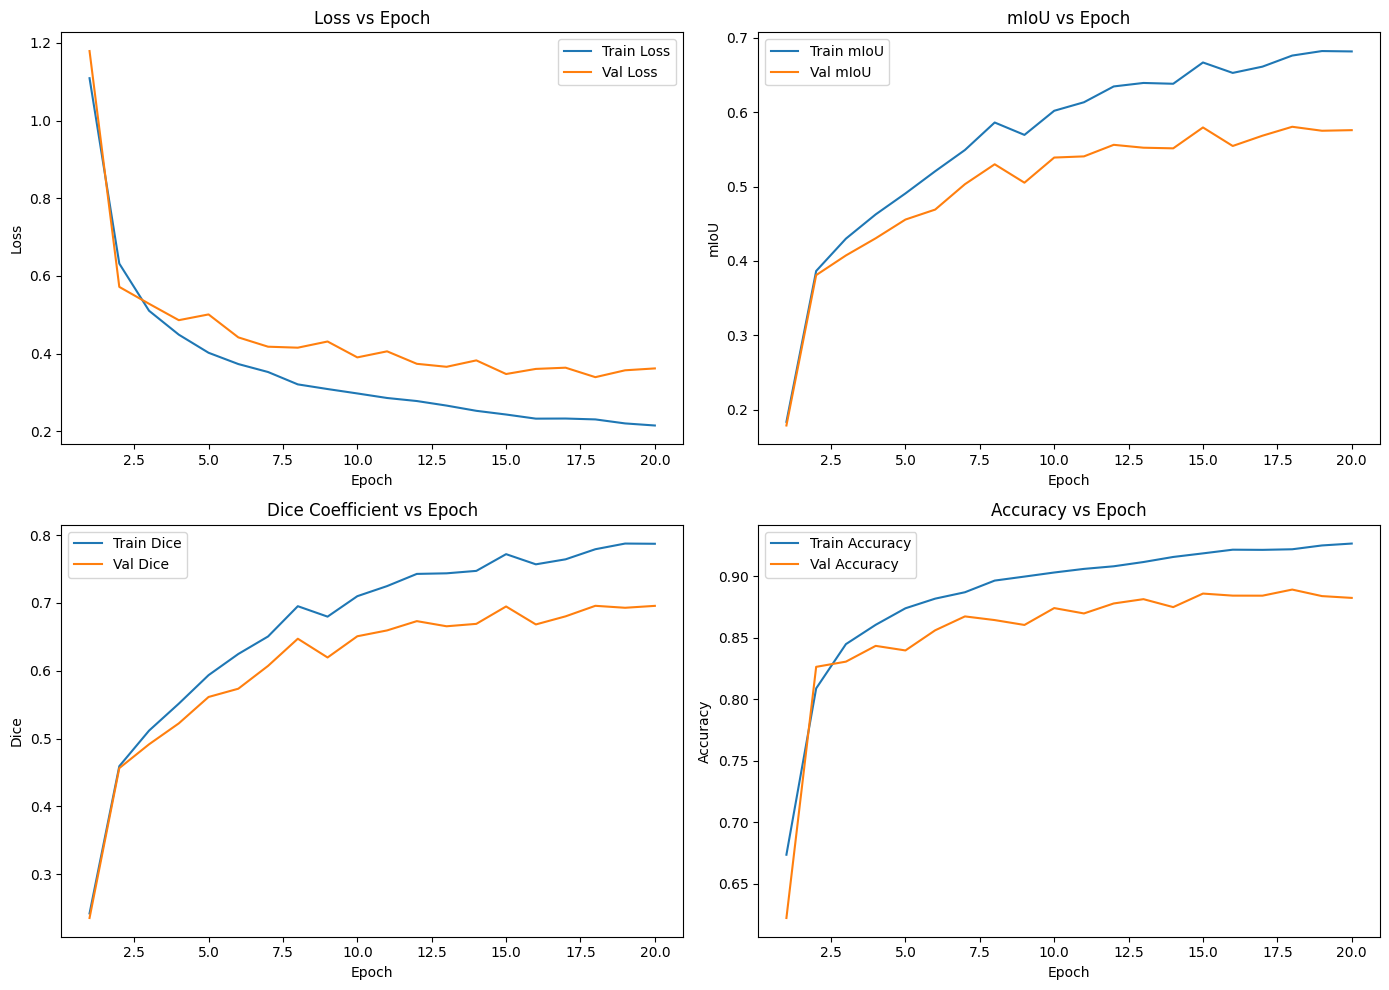

In [ ]:
# Plot Metrics Over Epochs

ep = list(range(1, NUM_EPOCHS+1))

plt.figure(figsize=(14,10))

# Loss
plt.subplot(2,2,1)
plt.plot(ep, train_losses, label='Train Loss')
plt.plot(ep, val_losses,   label='Val Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

# mIoU
plt.subplot(2,2,2)
plt.plot(ep, train_mious, label='Train mIoU')
plt.plot(ep, val_mious,   label='Val mIoU')
plt.title('mIoU vs Epoch')
plt.xlabel('Epoch'); plt.ylabel('mIoU'); plt.legend()

# Dice
plt.subplot(2,2,3)
plt.plot(ep, train_dices, label='Train Dice')
plt.plot(ep, val_dices,   label='Val Dice')
plt.title('Dice Coefficient vs Epoch')
plt.xlabel('Epoch'); plt.ylabel('Dice'); plt.legend()

# Accuracy
plt.subplot(2,2,4)
plt.plot(ep, train_accs, label='Train Accuracy')
plt.plot(ep, val_accs,   label='Val Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Load Checkpoint + Metrics in a New Notebook

# import torch

# ckpt_path = 'checkpoints/fast_scnn_epoch70.pth'  # adjust as needed
# ckpt = torch.load(ckpt_path, map_location=DEVICE)

# # Restore model & optimizer & scheduler
# model.load_state_dict(ckpt['model_state'])
# optimizer.load_state_dict(ckpt['opt_state'])
# scheduler.load_state_dict(ckpt['sched_state'])

# # Restore epoch and metric histories
# start_epoch  = ckpt['epoch']
# train_losses = ckpt['train_losses']
# val_losses   = ckpt['val_losses']
# train_mious  = ckpt['train_mious']
# val_mious    = ckpt['val_mious']
# train_dices  = ckpt['train_dices']
# val_dices    = ckpt['val_dices']

# print(f"Loaded checkpoint from epoch {start_epoch}")


In [ ]:
# Save Checkpoint + Metrics after Training

os.makedirs('checkpoints', exist_ok=True)
ckpt_path = f'checkpoints/fast_scnn_epoch{NUM_EPOCHS}.pth'

torch.save({
    'epoch'         : NUM_EPOCHS,
    'model_state'   : model.state_dict(),
    'opt_state'     : optimizer.state_dict(),
    'sched_state'   : scheduler.state_dict(),
    'train_losses'  : train_losses,
    'val_losses'    : val_losses,
    'train_mious'   : train_mious,
    'val_mious'     : val_mious,
    'train_dices'   : train_dices,
    'val_dices'     : val_dices,
    'train_accs'    : train_accs,
    'val_accs'      : val_accs,
}, ckpt_path)

print(f"Saved checkpoint and metrics to {ckpt_path}")


Saved checkpoint and metrics to checkpoints/fast_scnn_epoch20.pth


<h1>Evaluation</h1>

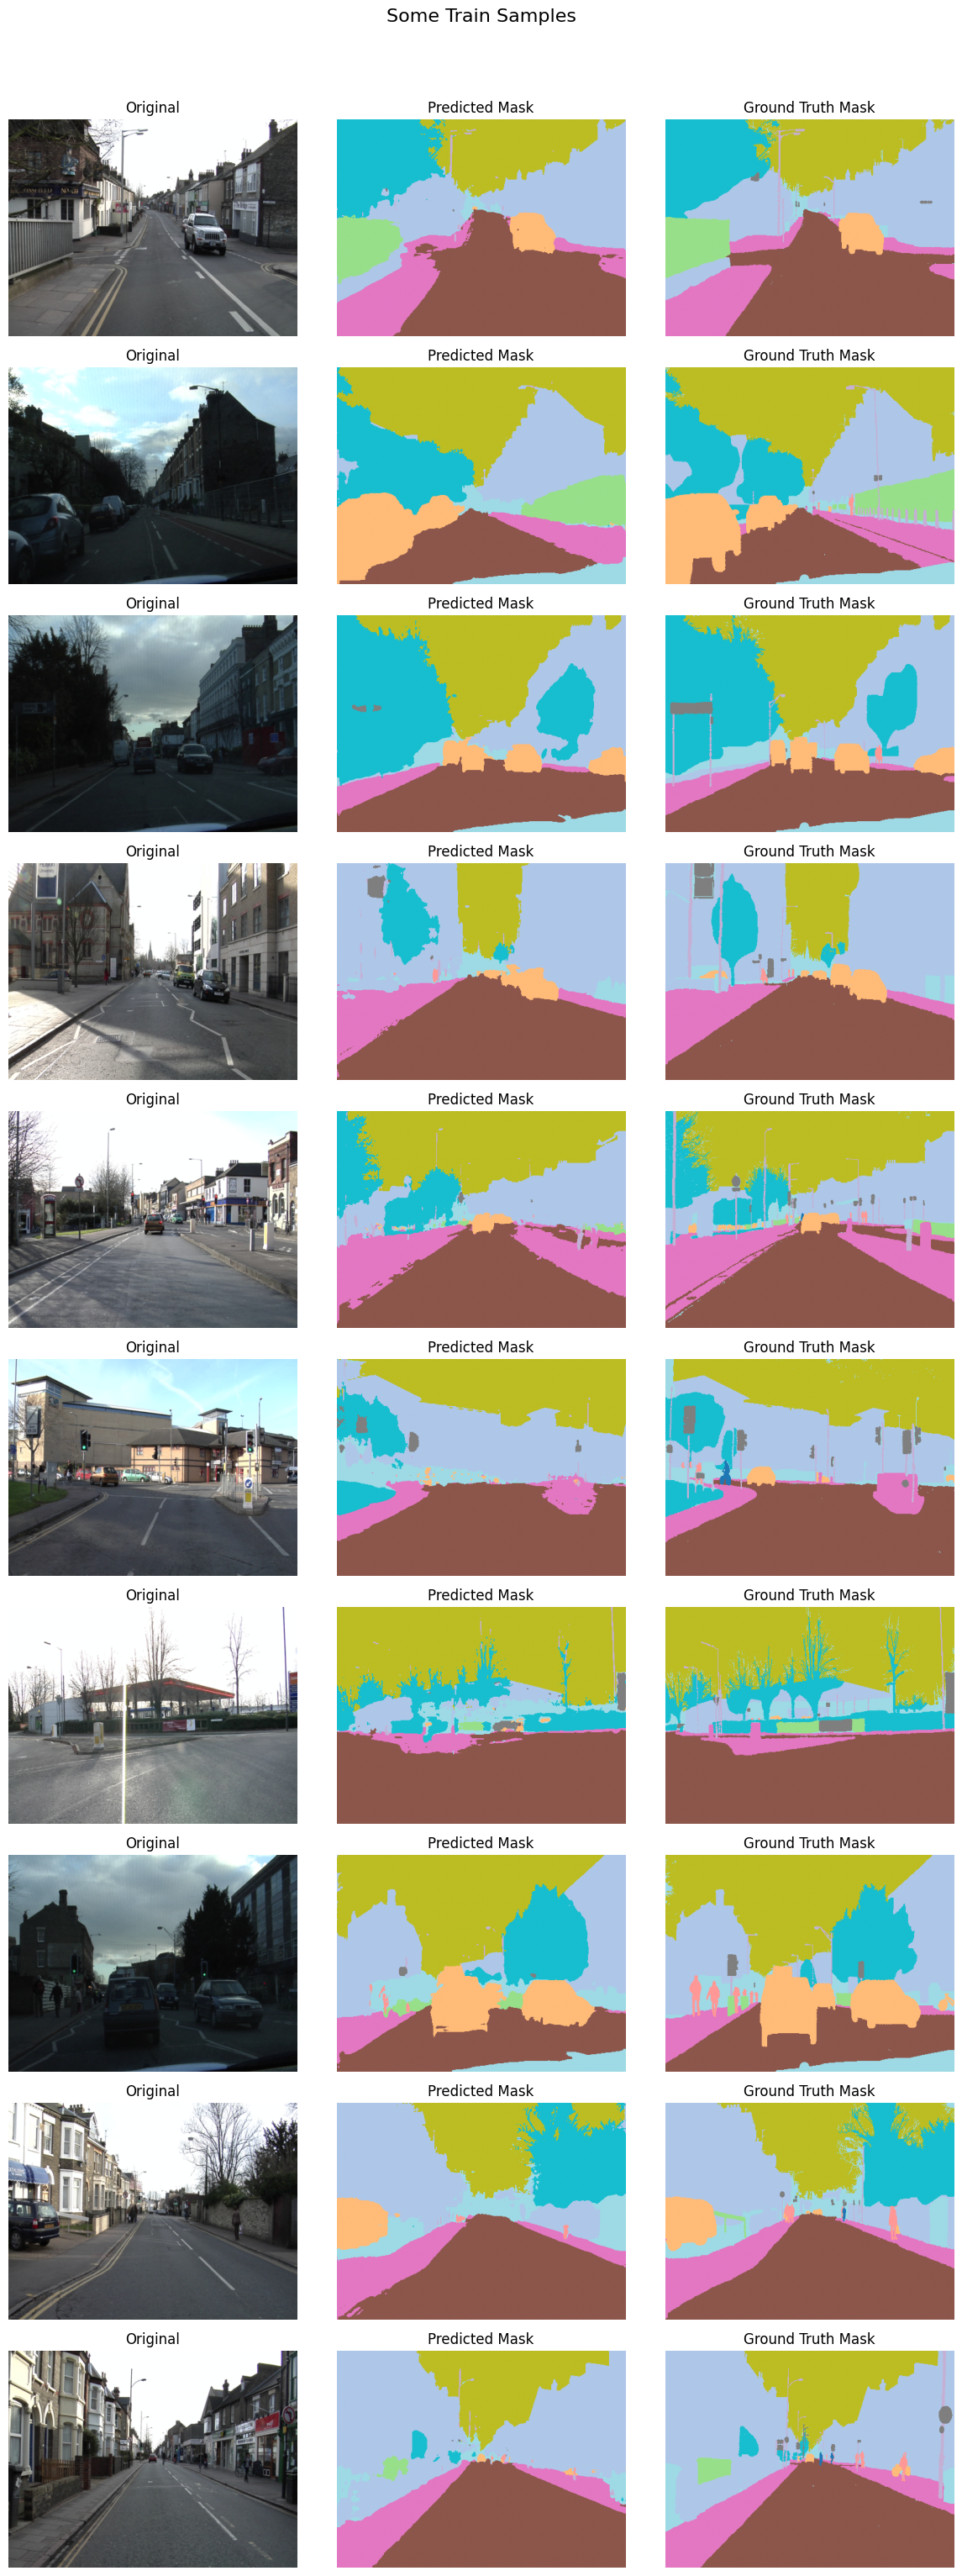

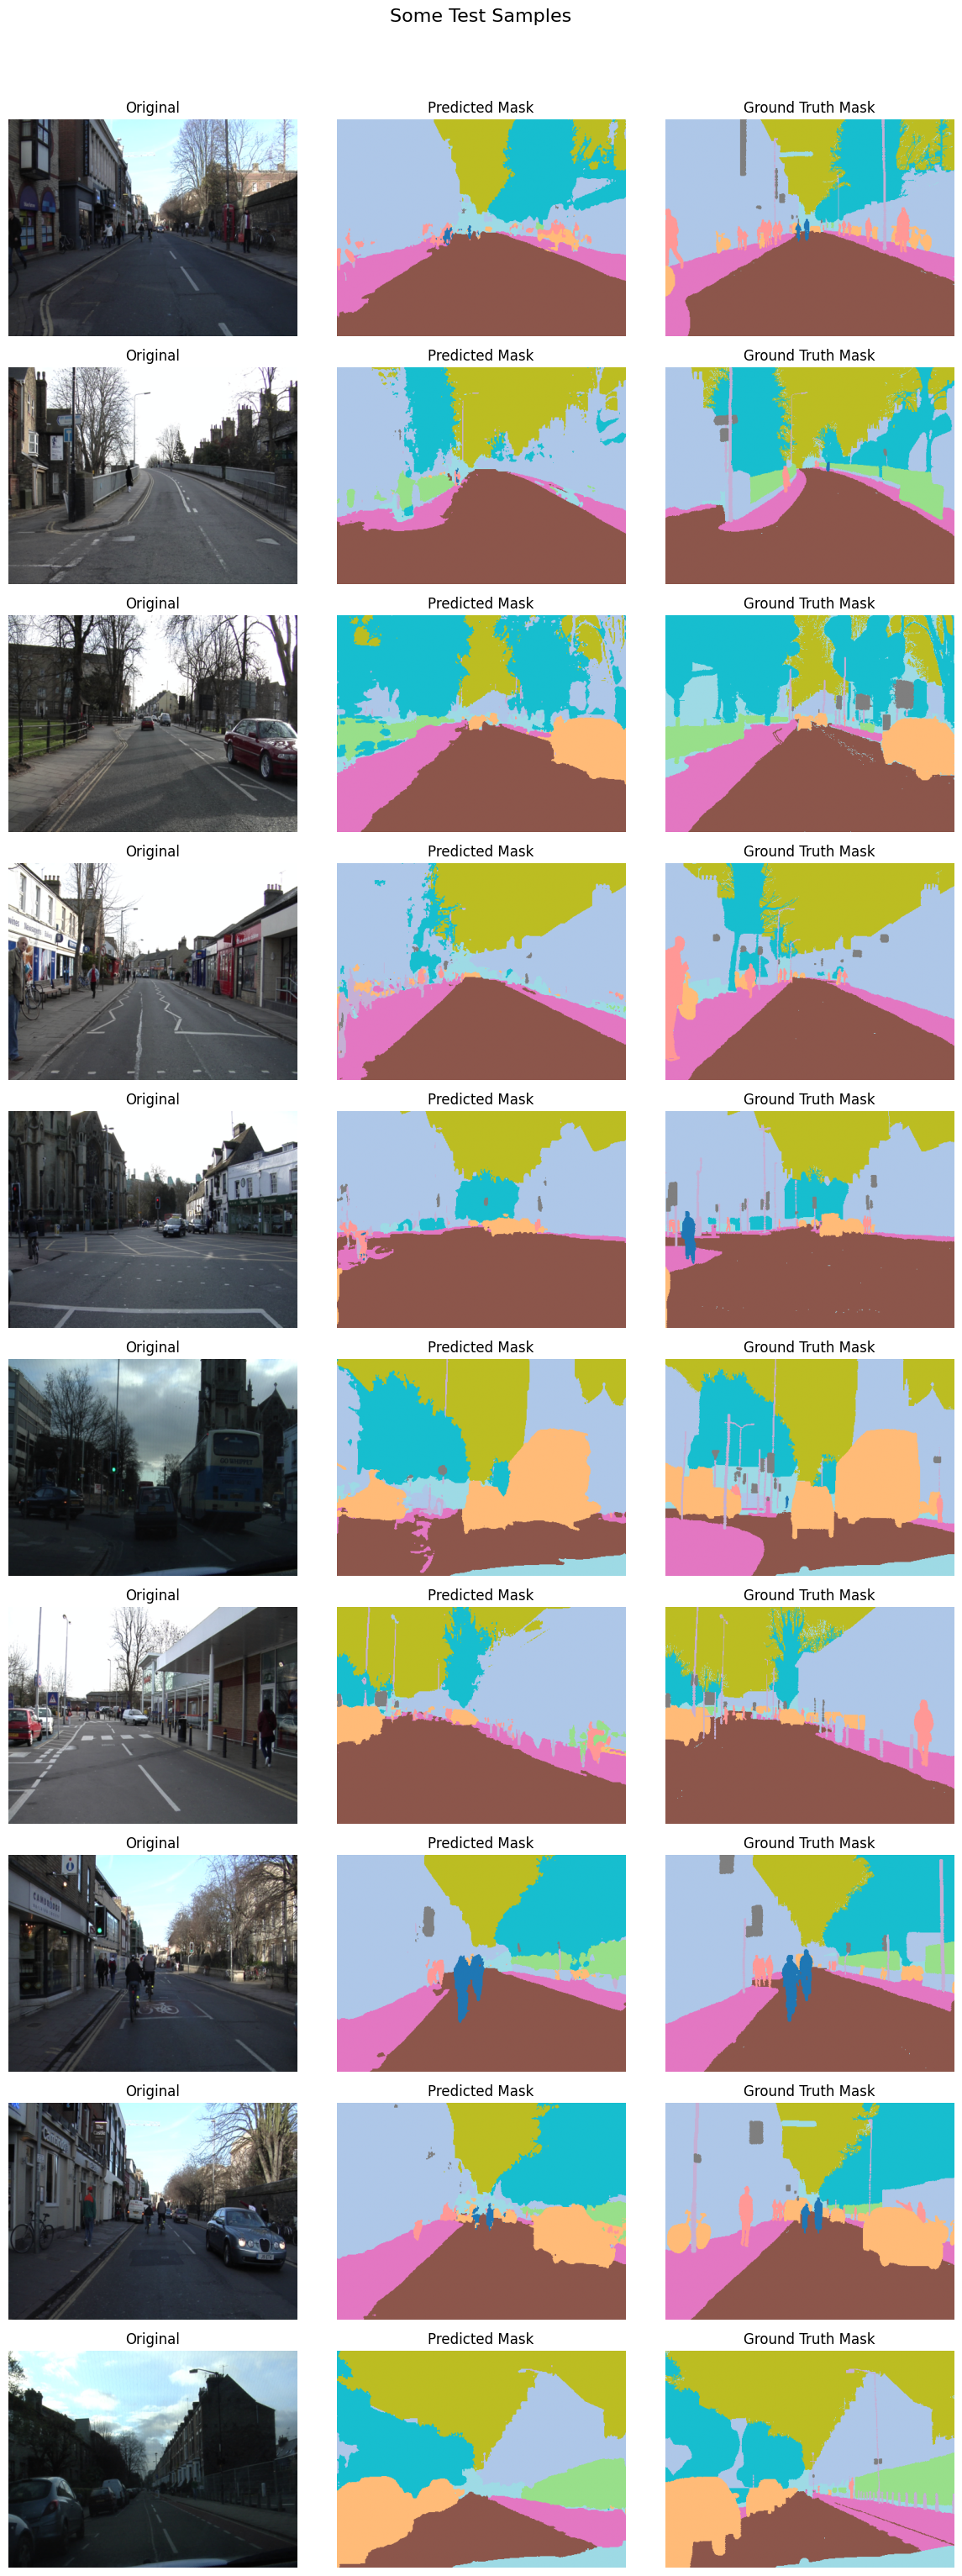

In [ ]:
# Visualization

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import random

model.eval()

def visualize_random_samples(dataset, title, n=10, seed=42):
    random.seed(seed)
    indices = random.sample(range(len(dataset)), n)
    fig, axes = plt.subplots(n, 3, figsize=(12, 3*n))
    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        inp = img.unsqueeze(0).to(DEVICE)  # [1,3,H,W]
        with torch.no_grad():
            pred = model(inp)
            pred = F.interpolate(pred, size=mask.shape, mode='bilinear', align_corners=False)
            pred_label = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()

        img_np = img.permute(1,2,0).cpu().numpy()
        mean = np.array([0.485,0.456,0.406])
        std  = np.array([0.229,0.224,0.225])
        img_np = np.clip(std * img_np + mean, 0, 1)

        gt_mask = mask.cpu().numpy()

        # Plot
        axes[i,0].imshow(img_np)
        axes[i,0].set_title("Original")
        axes[i,0].axis('off')

        axes[i,1].imshow(pred_label, cmap='tab20', vmin=0, vmax=NUM_CLASSES-1)
        axes[i,1].set_title("Predicted Mask")
        axes[i,1].axis('off')

        axes[i,2].imshow(gt_mask, cmap='tab20', vmin=0, vmax=NUM_CLASSES-1)
        axes[i,2].set_title("Ground Truth Mask")
        axes[i,2].axis('off')

    fig.suptitle(title, y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_random_samples(train_ds, "Some Train Samples")
visualize_random_samples(val_subset, "Some Test Samples")


In [ ]:
def evaluate(model, loader, criterion, num_classes, label_names, device):
    model.eval()
    val_loss = 0.0
    intersection = torch.zeros(num_classes, dtype=torch.float32, device=device)
    union = torch.zeros(num_classes, dtype=torch.float32, device=device)

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Evaluating"):
            imgs = imgs.to(device)
            masks = masks.to(device)

            preds = model(imgs)
            preds = F.interpolate(preds, size=masks.shape[1:], mode='bilinear', align_corners=False)

            val_loss += criterion(preds, masks).item() * imgs.size(0)

            pred_labels = torch.argmax(preds, dim=1)
            pred_flat = pred_labels.view(-1)
            mask_flat = masks.view(-1)

            for cls in range(num_classes):
                pred_i = (pred_flat == cls)
                mask_i = (mask_flat == cls)
                intersection[cls] += (pred_i & mask_i).sum().float()
                union[cls] += (pred_i | mask_i).sum().float()

    avg_loss = val_loss / len(loader.dataset)
    iou = intersection / (union + 1e-6)
    miou = iou.mean().item()
    return avg_loss, miou, iou.cpu().tolist()

val_loss, val_miou, per_class_iou = evaluate(
    model, val_loader, criterion, NUM_CLASSES, label_names, DEVICE
)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation mIoU: {val_miou:.4f}\n")

print("Per-class IoU:")
for cls_idx, iou in enumerate(per_class_iou):
    name = label_names[cls_idx]
    print(f"  Class {cls_idx:2d} ({name:12s}): IoU = {iou:.4f}")


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.57s/it]

Validation Loss: 0.3618
Validation mIoU: 0.5760

Per-class IoU:
  Class  0 (Bicyclist   ): IoU = 0.5456
  Class  1 (Building    ): IoU = 0.7784
  Class  2 (Car         ): IoU = 0.7218
  Class  3 (Fence       ): IoU = 0.4395
  Class  4 (Pedestrian  ): IoU = 0.2988
  Class  5 (Pole        ): IoU = 0.1449
  Class  6 (Road        ): IoU = 0.9383
  Class  7 (Sidewalk    ): IoU = 0.7501
  Class  8 (SignSymbol  ): IoU = 0.3102
  Class  9 (Sky         ): IoU = 0.9196
  Class 10 (Tree        ): IoU = 0.7226
  Class 11 (Void        ): IoU = 0.3415
